## 빅데이터 실습

### 다나와 무선청소기 상품분석

#### 데이터 수집

##### 셀레니움 사용

In [212]:
from selenium import webdriver
import time
from bs4 import BeautifulSoup
import pandas as pd
from urllib import parse # url encode
from tqdm import tqdm, tqdm_notebook
import random

In [ ]:
driver = webdriver.Chrome()
url = 'https://search.danawa.com/dsearch.php?k1=%EC%97%90%EC%96%B4%EB%A9%94%EC%9D%B4%EB%93%9C+%EC%8A%A4%EB%A7%88%ED%8A%B8%ED%83%80%EC%9B%8C&module=goods&act=dispMain'
driver.get(url)
time.sleep(5.0)

In [ ]:
html = driver.page_source
soup = BeautifulSoup(html,'html.parser')

In [ ]:
prodItems = soup.select('ul.product_list>li.prod_item')

In [ ]:
prodItems[0].select('p.prod_name > a')[0].text.strip()

In [ ]:
prodItems[0].select('div.spec_list')[0].text.strip().replace('\t','')

In [ ]:
# isdecimal 숫자가아니면 False 반환
prodItems[0].select('input')[1].get('value').isdecimal()

##### 다나와 무선청소기 웹크롤링 수정
- 가격 외에는 안들어오도록 변환

In [ ]:
## 검색어, 페이지를 변경하면서 URL 생성함수
def getSearchPageUrl(keyword, page):
    ecKeyword = parse.quote(keyword)
    url = f'https://search.danawa.com/dsearch.php?query={ecKeyword}&originalQuery={ecKeyword}&previousKeyword={ecKeyword}&checkedInfo=N&volumeType=allvs&' + \
          f'page={page}&limit=120&sort=saveDESC&list=list&boost=true&tab=goods&addDelivery=N&coupangMemberSort=N&mode=simple&isInitTireSmartFinder=N&' + \
            'recommendedSort=N&defaultUICategoryCode=10325109&defaultPhysicsCategoryCode=72%7C80%7C81%7C0&defaultVmTab=3138&defaultVaTab=1098867&isZeroPrice=Y&' + \
            'quickProductYN=N&priceUnitSort=N&priceUnitSortOrder=A'
    return url

In [ ]:
def getProdItems(prodItems):
    prodData = []
    for prodItem in prodItems:
        try:
            product_name = prodItem.select('p.prod_name >a')[0].text.strip()
            product_spec = prodItem.select('div.spec_list')[0].text.strip().replace('\t','')
            if prodItem.select('input')[1].get('value').isdecimal() == True:
                product_price = prodItem.select('input')[1].get('value')
            else:
                product_price = 0
            product_reg_mon = prodItem.select('div.prod_sub_meta> dl>dd')[0].text.strip()
            prodData.append([product_name,product_spec,product_price,product_reg_mon])
        except:
            pass
    return prodData

In [ ]:
# 여러페이지 검색후 크롤링하는 작업

driver = webdriver.Chrome()

# 암묵적으로 맵 자원 로드를 위해서 3초 정도 대기한다.
driver.implicitly_wait(3)

keyword = '무선청소기'
startPage = 1
totalPage = 20
# 최종 저장 리스트
prodDataTotal = []

for page in tqdm(range(startPage,totalPage+1)):
    url = getSearchPageUrl(keyword,page)
    driver.get(url)
    #페이지 로딩이 완료될 때 까지 5초 대기
    time.sleep(5)
    
    # 상품 정보 추출
    html = driver.page_source
    soup = BeautifulSoup(html,'html.parser')
    prodItems = soup.select('ul.product_list > li.prod_item')
    prodItemList = getProdItems(prodItems)

    prodDataTotal += prodItemList


In [ ]:
len(prodDataTotal)

In [ ]:
dfprodDataTotal = pd.DataFrame(prodDataTotal)

In [ ]:
dfprodDataTotal.columns=['제품명','제품스펙','최저가','날짜']

In [ ]:
dfprodDataTotal.to_excel('./data/다나와_무선청소기_결과.xlsx',index= False)

##### 크롤링 데이터 전처리

In [ ]:
# 저장한 엑셀을 재로드
dfprodDanawa = pd.read_excel('./data/다나와_무선청소기_결과.xlsx')
dfprodDanawa.tail()

In [ ]:
dfprodDanawa.info()

In [ ]:
# 결측치 검색
condition = dfprodDanawa['제품스펙'].isnull() == True
dfprodDanawa[condition]

In [ ]:
# 결측치가 있는 행을 삭제   *axis = 1(열), 0(행)
dfprodDanawa = dfprodDanawa.dropna(axis=0)

In [ ]:
dfprodDanawa

In [ ]:
condition = dfprodDanawa['최저가'] == 0

In [ ]:
dfprodDanawa = dfprodDanawa[condition == 0]

In [ ]:
# 행을 삭제하면 인데스가 꼬임. 인덱스 초기화
dfprodDanawa.reset_index(drop=True, inplace=True)

In [ ]:
dfprodDanawa.info()

In [ ]:
# 회사명, 제품명 분리 split (''.n)  n = 자를 공백의 번호
dfprodDanawa['제품명'].head()[0].split(' ',1)

In [ ]:
# 회사명, 모델명 분리
compList = []
modelList = []
count = 0

for temp in dfprodDanawa['제품명']:
    titles = temp.split(' ',1)  # 길이가 2 배열 생성
    if (len(titles)) > 1 :
        compList.append(titles[0])
        modelList.append(titles[1])
    else:
        compList.append('')
        modelList.append(titles[0])
    count += 1
    

In [ ]:
# modelList 와 compList 는 서로 같은 len 값을 가져야한다
len(modelList)
len(compList)

In [ ]:
# 스펙목록 데이터
specList = dfprodDanawa.loc[0,'제품스펙'].split(' / ')

In [ ]:
useTime = []
suctionPow = []
for spec in specList:
    if '사용시간' in spec:
        useTime = spec
    elif '흡입력' in spec:
        suctionPow = spec
useTime.split(':')[1].strip()
suctionPow.split(':')[1].strip()

In [ ]:
# 카테고리, 사용시간, 흡입력 추출
CateList = []
useTimeList = []
suctionPowList = []

for spec in dfprodDanawa['제품스펙']:
    specList = spec.split(' / ')
    category = specList[0]
    CateList.append(category)
    useTimeVal = None
    suctionPowVal = None
    for temp in specList:
        if '사용시간' in temp.replace('[배터리] ',''):
            useTimeVal = temp
        elif '흡입력' in temp:
            suctionPowVal = temp

    if useTimeVal != None:
        useTime = useTimeVal.split(' ')[1].strip().replace('(최대)','')

    else:
        useTime =''

    if suctionPowVal != None:
        suctionPow = suctionPowVal.split(' ')[1].strip()
    else:
        suctionPow =''
    if useTime == '사용시간:':
        useTime = useTimeVal.split(' ')[2].strip().replace('(최대)','')
    useTimeList.append(useTime)
    suctionPowList.append(suctionPow)


In [ ]:
useTimeList

In [ ]:
# 사용시간 단위를 통일
def convertHourToMin(time):
    try:
        if'시간' in time:
            hour = time.split('시간')[0]
            if '분' in time:
                minute = time.split('시간')[-1].split('분')[0]
            else:
                minute = 0
        else:
            hour = 0
            minute = time.split('분')[0]
        return int(hour)*60 + int(minute)
    except:
        pass

In [ ]:
newUseTimeList = []
for time in useTimeList :
    value = convertHourToMin(time)
    newUseTimeList.append(value)

In [ ]:
# 흡입력 단위 통일 1W = 1AW = 100pa
def convertPow(value):
    try:
        value = value.upper()
        if 'AW' in value or 'W' in value:
            result = value.replace('A','').replace('W','').replace(',','')
            result = int(result)
        elif 'PA' in value:
            result = value.replace('PA','').replace(',','')
            result = int(result)//100
        else:
            result = None
        
        return result
    except:
        return None

In [ ]:
newSuctionList = []
for power in suctionPowList:
    value = convertPow(power)
    newSuctionList.append(value)

In [ ]:
dfLast = pd.DataFrame()
dfLast['카테코리'] = CateList
dfLast['회사명'] = compList
dfLast['제품명'] = modelList
dfLast['가격'] = dfprodDanawa['최저가']
dfLast['사용시간(분)'] = newUseTimeList
dfLast['흡입력'] = newSuctionList

In [ ]:
dfLast.tail()

In [ ]:
dfLast.to_excel('./data/무선청소기_최종.xlsx',index=False)

In [ ]:
dfCleaner = pd.read_excel('./data/무선청소기_최종.xlsx')

In [ ]:
# 결측치 검색
dfCleaner.isnull().sum()

In [ ]:
condition = dfCleaner['회사명'].isnull() ==True
var1 = dfCleaner[condition]
dfCleaner

In [ ]:
dfCleaner['회사명'].fillna('무명',inplace=True)

In [ ]:
dfCleaner[condition]

In [ ]:
dfCleaner.info()

In [ ]:
dfCleaner.fillna(0,inplace=True)

In [ ]:
dfCleaner['카테코리'].value_counts()

In [ ]:
condition = dfCleaner['카테코리'].isin(['핸디스틱청소기','핸디스틱청소기+로봇청소기','진공청소기'])
dfDataFinal = dfCleaner[condition]

In [ ]:
dfDataFinal.to_excel('./data/다나와_진짜최종.xlsx',index=False)

In [ ]:
# 인덱스가 꼬였기때문에 재 호출
dfDataFinal = pd.read_excel('./data/다나와_진짜최종.xlsx')

In [ ]:
# 흡입력 기준으로 정렬
suctionTopList = dfDataFinal.sort_values(['흡입력'],ascending = False)
suctionTopList.head()

In [ ]:
# 사용시간 기준으로 정렬
useTimeTopList = dfDataFinal.sort_values(['사용시간(분)'],ascending = False)
useTimeTopList.head()

In [ ]:
#사용시간, 흡입력 기준으로 정렬
topList = dfDataFinal.sort_values(['사용시간(분)','흡입력'],ascending = False)
topList.head()

In [ ]:
# 가성비 좋은 제품 찾기
priceMean = dfDataFinal['가격'].mean()  #47만
sucationMean = dfDataFinal['흡입력'].mean()    # 117W
useTimeMean = dfDataFinal['사용시간(분)'].mean()  # 39분
print(f'평균가격: {priceMean:,.1f}원, 평균흡입력: {sucationMean:,.2f}W, 평균사용시간: {useTimeMean:,.2f}분')

In [ ]:
# 평균보다 좋은 제품들
cond1 = dfDataFinal['가격'] <= priceMean
cond2 = dfDataFinal['흡입력'] >= sucationMean
cond3 = dfDataFinal['사용시간(분)'] >= useTimeMean

In [183]:
chartData = dfDataFinal[cond1 & cond2 & cond3]

##### 데이터 시각화

In [181]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [182]:
# 한글 깨짐 문제 해결
from matplotlib import rcParams, font_manager, rc

font_path = 'C:/Windows/Fonts/malgun.ttf'
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font',family=font)
rcParams['axes.unicode_minus'] = False

In [200]:
suctionMax = chartData['흡입력'].max()
useTimeMax = chartData['사용시간(분)'].max()
useTimeMean = chartData['사용시간(분)'].mean()
sucationMean = chartData['흡입력'].mean()

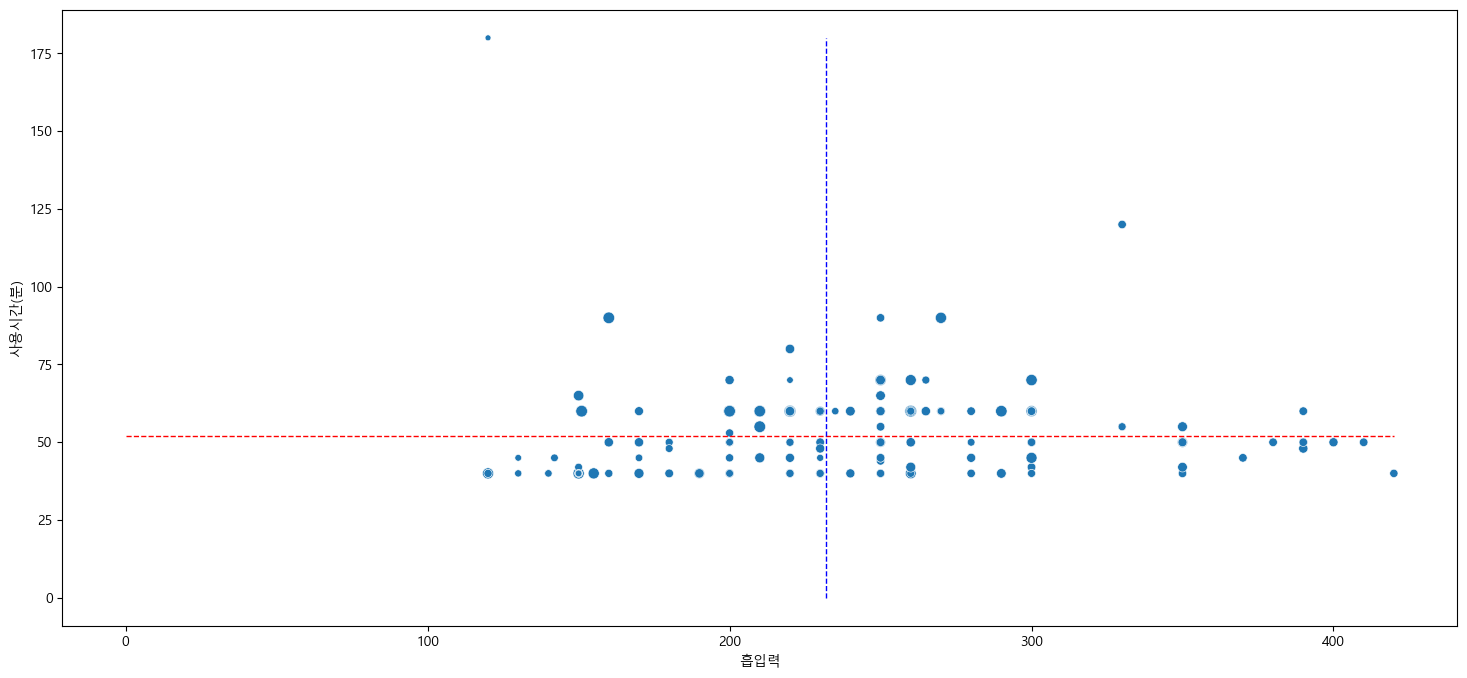

In [203]:
plt.figure(figsize=(18,8))

sns.scatterplot(data=chartData,x='흡입력',y='사용시간(분)',size = '가격',hue=chartData['카테코리'],legend=False)
plt.plot([0,suctionMax],[useTimeMean,useTimeMean],'r--',lw =1)
plt.plot([sucationMean,sucationMean],[0,useTimeMax],'b--',lw=1)

plt.show()

In [204]:
# 인기제품 데이터 시각화
chartDataTop = chartData[:20]

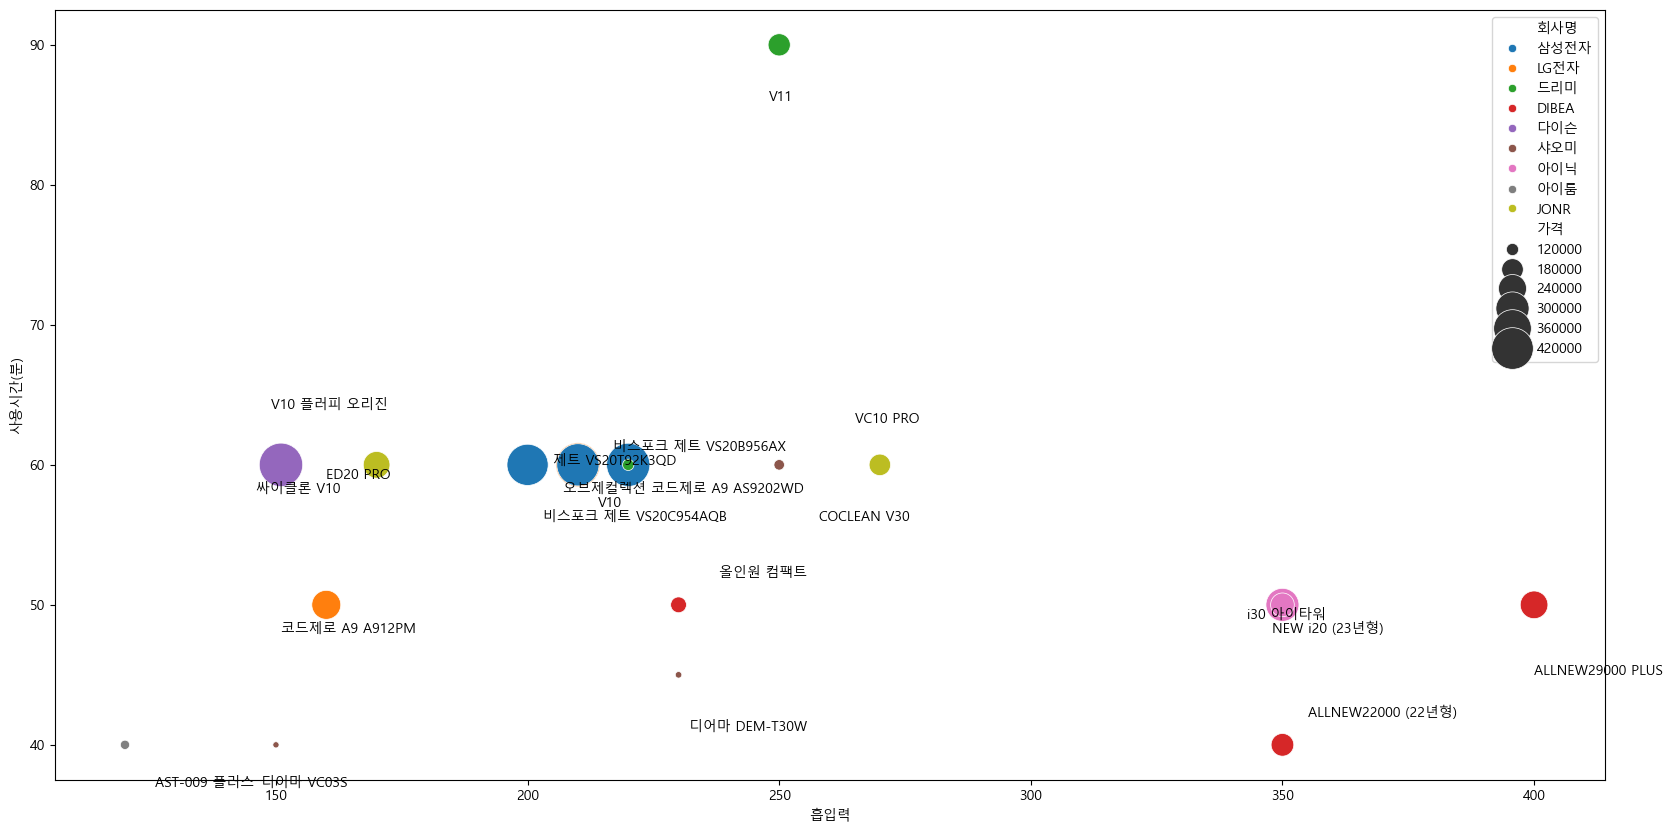

In [217]:
fig = plt.figure(figsize=(20,10))
sns.scatterplot(data=chartDataTop,x='흡입력',y='사용시간(분)',size = '가격',sizes=(20,1000),hue = chartDataTop['회사명'])

for index, row in chartDataTop.iterrows():
    x = row['흡입력'] + random.randrange(-10,10)
    y = row['사용시간(분)'] + random.randrange(-5,5)
    s = row['제품명']
    plt.text(x,y,s,size=10)
plt.show()


##### 결론
데이터분석을 위한 전처리 과정 필수 *빈값이 많을수록 힘들다
예상과 결과는 다르다